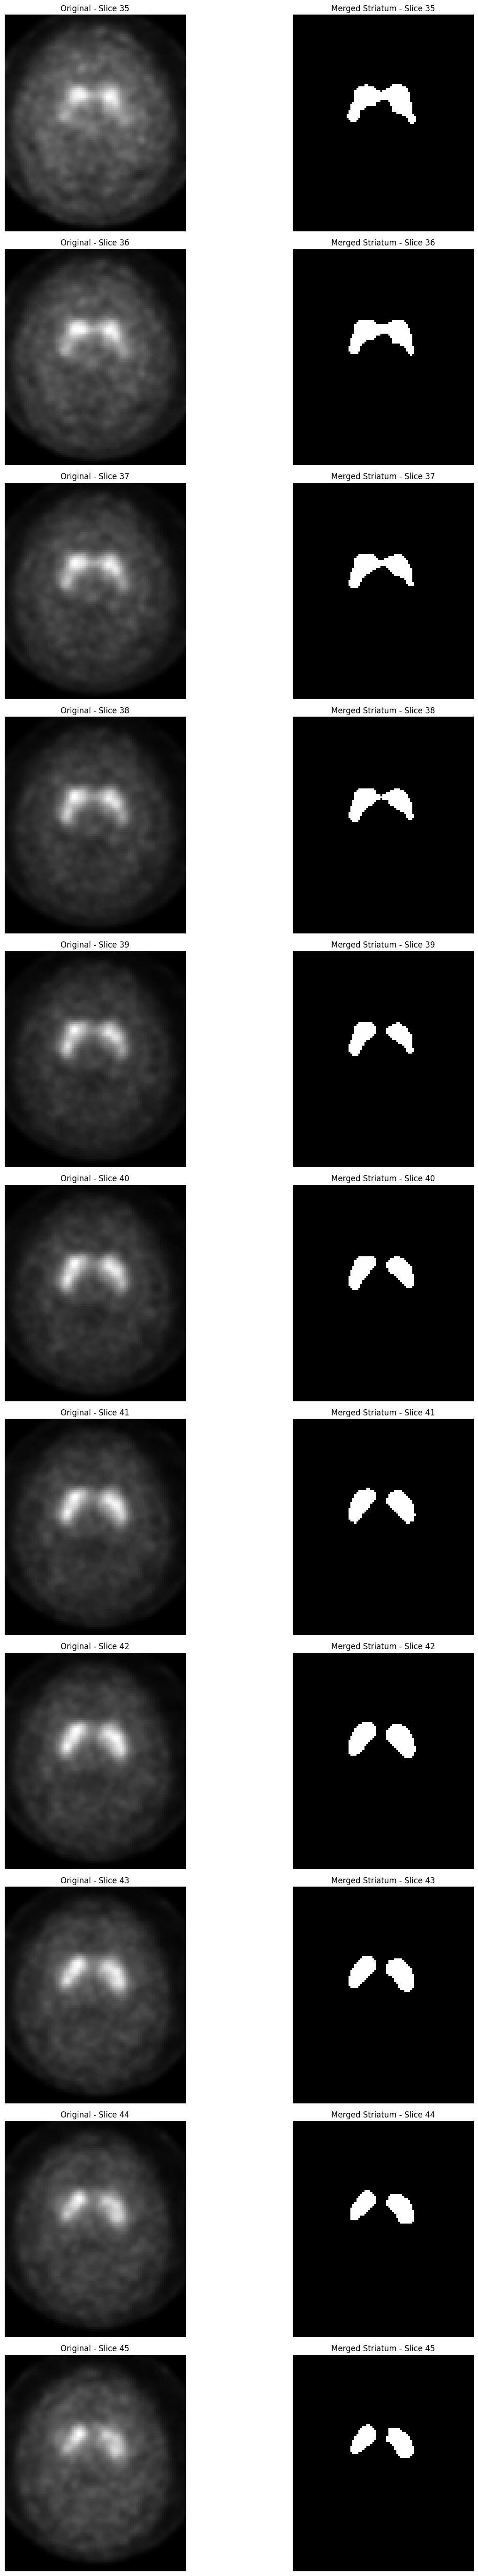

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage import measure

# Load DICOM data
dicom_dir = "B:/Data set/DAT_PRE-P_S-ID(4100-4478)/PPMI/4100/Reconstructed_DaTSCAN/2012-11-13_13_33_30.0/I360623"
dicom_files = sorted([os.path.join(dicom_dir, file) for file in os.listdir(dicom_dir) if file.endswith('.dcm')])

try:
    dicom_data = [pydicom.dcmread(file) for file in dicom_files]
    preprocessed_image_data = np.stack([dicom.pixel_array for dicom in dicom_data])
    
    # Remove single channel dimension if present
    preprocessed_image_data = np.squeeze(preprocessed_image_data)
except Exception as e:
    print("Error loading DICOM data:", e)
    exit()

# Parameters
threshold_value = 0.56789  # Threshold for segmentation, adjust as needed

# Segmentation for coronal slices
coronal_slices_to_visualize = [35,36,37,38,39, 40, 41, 42, 43, 44,45]
num_slices = len(coronal_slices_to_visualize)

fig, axes = plt.subplots(num_slices, 2, figsize=(15, 5 * num_slices))

merged_striatum_image = np.zeros_like(preprocessed_image_data, dtype=np.uint8)

for i, slice_index in enumerate(coronal_slices_to_visualize):
    # Get the coronal slice
    coronal_slice = preprocessed_image_data[slice_index, :, :]

    # Thresholding to obtain the brightest region
    binary_image = coronal_slice > np.max(coronal_slice) * threshold_value

    # Label connected components
    labeled_image, num_labels = measure.label(binary_image, connectivity=2, return_num=True)

    # Find the left and right regions
    left_region_label = labeled_image[:, :coronal_slice.shape[1] // 2].max()
    right_region_label = labeled_image[:, coronal_slice.shape[1] // 2:].max()

    # Extract the segmented left and right regions
    left_region_mask = labeled_image == left_region_label
    right_region_mask = labeled_image == right_region_label

    # Overlay the masks on the original image
    merged_striatum_image[slice_index, :, :coronal_slice.shape[1] // 2][left_region_mask[:, :coronal_slice.shape[1] // 2]] = 255
    merged_striatum_image[slice_index, :, coronal_slice.shape[1] // 2:][right_region_mask[:, coronal_slice.shape[1] // 2:]] = 255

    # Original image
    axes[i, 0].imshow(coronal_slice, cmap='gray')
    axes[i, 0].set_title(f'Original - Slice {slice_index}')
    axes[i, 0].axis('off')

    # Segmented left and right regions
    axes[i, 1].imshow(merged_striatum_image[slice_index], cmap='gray')
    axes[i, 1].set_title(f'Merged Striatum - Slice {slice_index}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


Image Shape: (91, 109, 91)


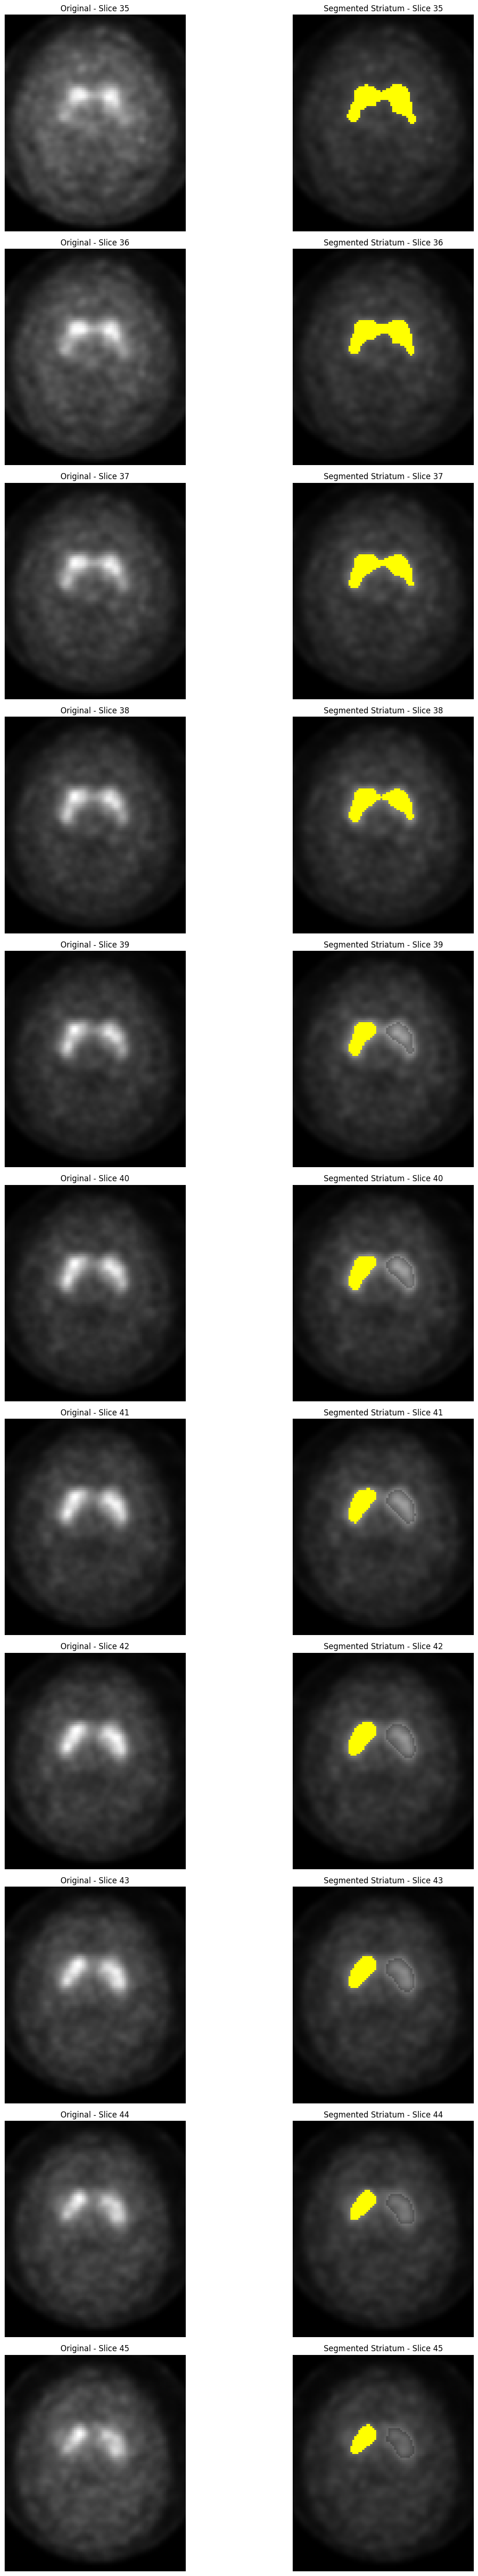

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage import measure, color

# Load DICOM data
dicom_dir = "B:/Data set/DAT_PRE-P_S-ID(4100-4478)/PPMI/4100/Reconstructed_DaTSCAN/2012-11-13_13_33_30.0/I360623"
dicom_files = sorted([os.path.join(dicom_dir, file) for file in os.listdir(dicom_dir) if file.endswith('.dcm')])

try:
    dicom_data = [pydicom.dcmread(file) for file in dicom_files]
    preprocessed_image_data = np.stack([dicom.pixel_array for dicom in dicom_data])
    
    # Remove single channel dimension if present
    preprocessed_image_data = np.squeeze(preprocessed_image_data)
except Exception as e:
    print("Error loading DICOM data:", e)
    exit()

# Check the dimensions of the preprocessed image data
print("Image Shape:", preprocessed_image_data.shape)

# Parameters
threshold_value = 0.5678  # Threshold for segmentation, adjust as needed

# Segmentation for coronal slices
coronal_slices_to_visualize = [35,36,37,38,39, 40, 41, 42, 43, 44,45]
num_slices = len(coronal_slices_to_visualize)

fig, axes = plt.subplots(num_slices, 2, figsize=(15, 5 * num_slices))

for i, slice_index in enumerate(coronal_slices_to_visualize):
    # Get the coronal slice
    coronal_slice = preprocessed_image_data[slice_index, :, :]

    # Thresholding to obtain the brightest region
    binary_image = coronal_slice > np.max(coronal_slice) * threshold_value

    # Label connected components
    labeled_image, num_labels = measure.label(binary_image, connectivity=2, return_num=True)

    # Find the largest connected component (assumed to be the striatum)
    region_props = measure.regionprops(labeled_image, intensity_image=coronal_slice)
    brightest_region_label = None
    brightest_mean_intensity = 0
    for region in region_props:
        if region.mean_intensity > brightest_mean_intensity:
            brightest_mean_intensity = region.mean_intensity
            brightest_region_label = region.label

    # Create mask for the brightest region
    brightest_region_mask = labeled_image == brightest_region_label

    # Overlay the mask on the original image
    masked_image = color.label2rgb(labeled_image, image=coronal_slice, bg_label=0, bg_color=None, colors=['black'], alpha=0.3, image_alpha=1)
    masked_image[brightest_region_mask] = [1, 1, 0]  # Highlight brightest region with yellow color

    # Original image
    axes[i, 0].imshow(coronal_slice, cmap='gray')
    axes[i, 0].set_title(f'Original - Slice {slice_index}')
    axes[i, 0].axis('off')

    # Segmented striatum region
    axes[i, 1].imshow(masked_image)
    axes[i, 1].set_title(f'Segmented Striatum - Slice {slice_index}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()